# K Nearest Neighbors

In [28]:
import pickle
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from pprint import pprint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import ShuffleSplit
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

First, we load the data:



In [29]:
# Dataframe
path_df = "C:/Users/asus-pc/Documents/PBA/Tugas Akhir/Untitled Folder/Pickles_title/df.pickle"
with open(path_df, 'rb') as data:
    df = pickle.load(data)

# features_train
path_features_train = "C:/Users/asus-pc/Documents/PBA/Tugas Akhir/Untitled Folder/Pickles_title/features_train.pickle"
with open(path_features_train, 'rb') as data:
    features_train = pickle.load(data)

# labels_train
path_labels_train = "C:/Users/asus-pc/Documents/PBA/Tugas Akhir/Untitled Folder/Pickles_title/labels_train.pickle"
with open(path_labels_train, 'rb') as data:
    labels_train = pickle.load(data)

# features_test
path_features_test = "C:/Users/asus-pc/Documents/PBA/Tugas Akhir/Untitled Folder/Pickles_title/features_test.pickle"
with open(path_features_test, 'rb') as data:
    features_test = pickle.load(data)

# labels_test
path_labels_test = "C:/Users/asus-pc/Documents/PBA/Tugas Akhir/Untitled Folder/Pickles_title/labels_test.pickle"
with open(path_labels_test, 'rb') as data:
    labels_test = pickle.load(data)

Let's check the dimension of our feature vectors:

In [30]:
print(features_train.shape)
print(features_test.shape)

(2676, 300)
(473, 300)


## Cross-Validation for Hyperparameter tuning

First, we can see what hyperparameters the model has:

In [31]:
knnc_0 =KNeighborsClassifier()

print('Parameters currently in use:\n')
pprint(knnc_0.get_params())

Parameters currently in use:

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}


We'll tune the following ones:

* `K`: Number of neighbors to use by default for queries.

In this case, since there is only one hyperparameter, we'll perform an exhaustive search directly:

### Grid Search Cross Validation

We first need to define the grid:

In [32]:
# Create the parameter grid 
n_neighbors = [int(x) for x in np.linspace(start = 1, stop = 500, num = 100)]

param_grid = {'n_neighbors': n_neighbors}

# Create a base model
knnc = KNeighborsClassifier()

# Manually create the splits in CV in order to be able to fix a random_state (GridSearchCV doesn't have that argument)
cv_sets = ShuffleSplit(n_splits = 3, test_size = .33, random_state = 8)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=knnc, 
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=cv_sets,
                           verbose=1)

# Fit the grid search to the data
grid_search.fit(features_train, labels_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


GridSearchCV(cv=ShuffleSplit(n_splits=3, random_state=8, test_size=0.33, train_size=None),
             estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [1, 6, 11, 16, 21, 26, 31, 36, 41, 46,
                                         51, 56, 61, 66, 71, 76, 81, 86, 91, 96,
                                         101, 106, 111, 116, 121, 127, 132, 137,
                                         142, 147, ...]},
             scoring='accuracy', verbose=1)

The best parameters turn out to be:

In [33]:
print("The best hyperparameters from Grid Search are:")
print(grid_search.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:")
print(grid_search.best_score_)

The best hyperparameters from Grid Search are:
{'n_neighbors': 51}

The mean accuracy of a model with these hyperparameters is:
0.8766968325791855


Since the grid had a space of 5 between each element, we'll now cover all the possible `n_neighbors` near to 6:

In [34]:
n_neighbors = [51,52,53,54,55,56,57,58,59,60,61]
param_grid = {'n_neighbors': n_neighbors}

knnc = KNeighborsClassifier()
cv_sets = ShuffleSplit(n_splits = 3, test_size = .33, random_state = 8)

grid_search = GridSearchCV(estimator=knnc, 
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=cv_sets,
                           verbose=1)

grid_search.fit(features_train, labels_train)

Fitting 3 folds for each of 11 candidates, totalling 33 fits


GridSearchCV(cv=ShuffleSplit(n_splits=3, random_state=8, test_size=0.33, train_size=None),
             estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [51, 52, 53, 54, 55, 56, 57, 58, 59, 60,
                                         61]},
             scoring='accuracy', verbose=1)

The best parameters turn out to be:

In [35]:
print("The best hyperparameters from Grid Search are:")
print(grid_search.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:")
print(grid_search.best_score_)

The best hyperparameters from Grid Search are:
{'n_neighbors': 51}

The mean accuracy of a model with these hyperparameters is:
0.8766968325791855


Let's save the model in `best_knnc`:

In [36]:
best_knnc = grid_search.best_estimator_

In [37]:
best_knnc

KNeighborsClassifier(n_neighbors=51)

We now know the best KNN model. Let's fit it and see how it performs:

## Model fit and performance

Now, we can fit the model to our training data:

In [38]:
best_knnc.fit(features_train, labels_train)

KNeighborsClassifier(n_neighbors=51)

And get the predictions:

In [39]:
knnc_pred = best_knnc.predict(features_test)

The conditional class probabilities can be obtained by typing:

`knnc_pred = best_knnc.predict_proba(features_test)`

For performance analysis, we will use the confusion matrix, the classification report and the accuracy on both training and test data:

#### Training accuracy

In [40]:
# Training accuracy
print("The training accuracy is: ")
print(accuracy_score(labels_train, best_knnc.predict(features_train)))

The training accuracy is: 
0.8707025411061285


#### Test accuracy

In [41]:
# Test accuracy
print("The test accuracy is: ")
print(accuracy_score(labels_test, knnc_pred))

The test accuracy is: 
0.8562367864693446


#### Classification report

In [42]:
# Classification report
print("Classification report")
print(classification_report(labels_test,knnc_pred))

Classification report
              precision    recall  f1-score   support

           0       0.94      0.96      0.95       226
           1       0.90      0.76      0.82        86
           2       0.66      0.78      0.71        73
           3       0.79      0.74      0.76        88

    accuracy                           0.86       473
   macro avg       0.82      0.81      0.81       473
weighted avg       0.86      0.86      0.86       473



#### Confusion matrix

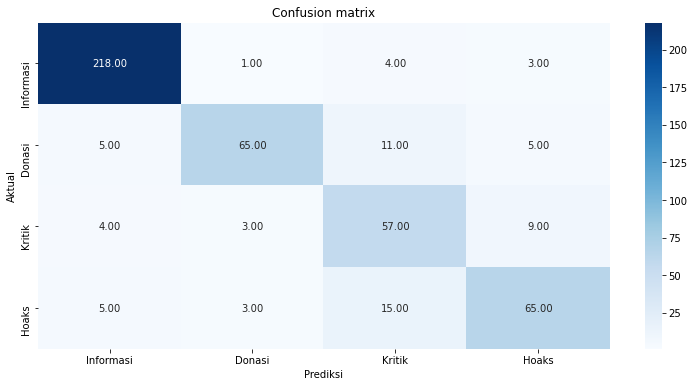

In [49]:
aux_df = df[['label', 'label_code']].drop_duplicates().sort_values('label_code')
conf_matrix = confusion_matrix(labels_test, knnc_pred)
aux_df['label'].values[0]='Informasi'
aux_df['label'].values[1]='Donasi'
aux_df['label'].values[2]='Kritik'
aux_df['label'].values[3]='Hoaks'
plt.figure(figsize=(12.8,6))
sns.heatmap(conf_matrix, 
            annot=True,
            xticklabels=aux_df['label'].values, 
            yticklabels=aux_df['label'].values,
            cmap="Blues",fmt='.2f')
plt.ylabel('Aktual')
plt.xlabel('Prediksi')
plt.title('Confusion matrix')
plt.show()

At this point, we could get the average time the model takes to get predictions. We want the algorithm to be fast since we are creating an app which will gather data from the internet and get the predicted categories. However, since the difference when predicting 10-20 observations will be very little, we won't take this into account.

However, the code below could do this task:

```python
features_time = features_train
elapsed_list = []
for i in range(0,10):
    
    start = time.time()
    predictions = best_lrc.predict(features_time)
    end = time.time()
    elapsed = end - start
    elapsed_list.append(elapsed)

mean_time_elapsed = np.mean(elapsed_list)
```

Let's see if the hyperparameter tuning process has returned a better model:

In [50]:
base_model = KNeighborsClassifier()
base_model.fit(features_train, labels_train)
accuracy_score(labels_test, base_model.predict(features_test))

0.8372093023255814

In [51]:
best_knnc.fit(features_train, labels_train)
accuracy_score(labels_test, best_knnc.predict(features_test))

0.8562367864693446

We can see that the default model (with 5 Nearest Neighbors) performs better. However, in our Grid Search Cross Validation process we tried with that number of neighbors. The reason why we may be getting this result is because de Grid Search performs a Cross Validation scheme, while this last comparison uses all training data.

We'll create a dataset with a model summary to compare models:

In [52]:
d = {
     'Model': 'KNN',
     'Training Set Accuracy': accuracy_score(labels_train, best_knnc.predict(features_train)),
     'Test Set Accuracy': accuracy_score(labels_test, knnc_pred)
}

df_models_knnc = pd.DataFrame(d, index=[0])

In [53]:
df_models_knnc

,Model,Training Set Accuracy,Test Set Accuracy
0,KNN,0.870703,0.856237


Let's save the model and this dataset:

In [29]:
with open('Models/best_knnc.pickle', 'wb') as output:
    pickle.dump(best_knnc, output)

with open('Models/df_models_knnc.pickle', 'wb') as output:
    pickle.dump(df_models_knnc, output)

In [30]:
# Dataframe
path_df = "C:/Users/asus-pc/Documents/PBA/Tugas Akhir/03. Feature Engineering/Pickles_title/df.pickle"
with open(path_df, 'rb') as data:
    df = pickle.load(data)
    
# X_train
path_X_train = "C:/Users/asus-pc/Documents/PBA/Tugas Akhir/03. Feature Engineering/Pickles_title/X_train.pickle"
with open(path_X_train, 'rb') as data:
    X_train = pickle.load(data)

# X_test
path_X_test = "C:/Users/asus-pc/Documents/PBA/Tugas Akhir/03. Feature Engineering/Pickles_title/X_test.pickle"
with open(path_X_test, 'rb') as data:
    X_test = pickle.load(data)

# y_train
path_y_train = "C:/Users/asus-pc/Documents/PBA/Tugas Akhir/03. Feature Engineering/Pickles_title/y_train.pickle"
with open(path_y_train, 'rb') as data:
    y_train = pickle.load(data)

# y_test
path_y_test = "C:/Users/asus-pc/Documents/PBA/Tugas Akhir/03. Feature Engineering/Pickles_title/y_test.pickle"
with open(path_y_test, 'rb') as data:
    y_test = pickle.load(data)

# features_train
path_features_train = "C:/Users/asus-pc/Documents/PBA/Tugas Akhir/03. Feature Engineering/Pickles_title/features_train.pickle"
with open(path_features_train, 'rb') as data:
    features_train = pickle.load(data)

# labels_train
path_labels_train = "C:/Users/asus-pc/Documents/PBA/Tugas Akhir/03. Feature Engineering/Pickles_title/labels_train.pickle"
with open(path_labels_train, 'rb') as data:
    labels_train = pickle.load(data)

# features_test
path_features_test = "C:/Users/asus-pc/Documents/PBA/Tugas Akhir/03. Feature Engineering/Pickles_title/features_test.pickle"
with open(path_features_test, 'rb') as data:
    features_test = pickle.load(data)

# labels_test
path_labels_test = "C:/Users/asus-pc/Documents/PBA/Tugas Akhir/03. Feature Engineering/Pickles_title/labels_test.pickle"
with open(path_labels_test, 'rb') as data:
    labels_test = pickle.load(data)
    
# SVM Model
path_model = "C:/Users/asus-pc/Documents/PBA/Tugas Akhir/04. Model Training/Models/best_knnc.pickle"
with open(path_model, 'rb') as data:
    svc_model = pickle.load(data)
    
# Category mapping dictionary
category_codes = {
    'notification of information': 0,
    'donation': 1,
    'criticism': 2,
    'hoax': 3,
}

category_names = {
    0: 'notification of information',
    1: 'donation',
    2: 'criticism',
    3: 'hoax'
}

ModuleNotFoundError: No module named 'sklearn.neighbors.classification'

In [78]:
predictions = svc_model.predict(features_test)

In [79]:
# Indexes of the test set
index_X_test = X_test.index

# We get them from the original df
df_test = df.loc[index_X_test]

# Add the predictions
df_test['prediction'] = predictions

# Clean columns
df_test = df_test[['title', 'label', 'label_code', 'prediction']]

# Decode
df_test['label_predicted'] = df_test['prediction']
df_test = df_test.replace({'label_predicted':category_names})

# Clean columns again
df_test = df_test[['title', 'label', 'label_predicted']]

In [80]:
df_test.head()

,title,label,label_predicted
2182,Update Corona Indonesia 24 Oktober 2020 dan Se...,notification of information,notification of information
1279,Pertamina Diminta Lihat Fluktuasi Harga Minyak...,criticism,notification of information
1729,UPDATE 17 Januari: Ada 145.482 Kasus Aktif Cov...,notification of information,notification of information
1477,"Sebaran 4.002 Kasus Positif Hari Ini, DKI-Jaba...",donation,donation
1964,UPDATE Corona 31 Maret di 32 Provinsi: Kasus B...,notification of information,notification of information


In [81]:
condition = (df_test['label'] != df_test['label_predicted'])

df_misclassified = df_test[condition]
df_misclassified.head(5)

,title,label,label_predicted
1279,Pertamina Diminta Lihat Fluktuasi Harga Minyak...,criticism,notification of information
858,"Kasus Positif Corona Bertambah 1.014, Jawa Tim...",donation,notification of information
1248,Pemprov DKI Proyeksikan Dana Rp171 Miliar Bant...,donation,criticism
2511,"Update Covid-19 Mingguan: Masih Tinggi, Persen...",notification of information,criticism
1531,Setelah Pulang dari Jakarta dan Berobat di Rum...,donation,criticism


In [82]:
def output_article(row_article):
    print('Actual Category: %s' %(row_article['label']))
    print('Predicted Category: %s' %(row_article['label_predicted']))
    print('-------------------------------------------')
    print('Text: ')
    print('%s' %(row_article['title']))

In [85]:
import random
random.seed()
list_samples = random.sample(list(df_misclassified.index), 3)
list_samples

[3067, 3132, 1485]

In [86]:
output_article(df_misclassified.loc[list_samples[0]])

Actual Category: hoax
Predicted Category: criticism
-------------------------------------------
Text: 
Wahidin Klaim Tingkat Disiplin Protokol Kesehatan Warga Tangerang Raya 90 Persen
